# Proyecto Compañía de seguros - ML

# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [2]:
pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 99.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [39]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import NearestNeighbors
import math

from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [5]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [6]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [7]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2939,0,37.0,21400.0,0,0
3051,1,23.0,56900.0,4,0
1634,1,36.0,33800.0,1,0
358,1,32.0,50700.0,2,0
1328,0,47.0,30900.0,0,1
4013,0,26.0,44600.0,2,0
4304,0,35.0,39100.0,0,0
1222,1,46.0,32300.0,0,1
275,0,35.0,48700.0,1,0
2868,1,27.0,28800.0,2,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [9]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:
df['age'] = df['age'].astype(int)

In [10]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [11]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
print (df.describe())

            gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000  


Los datos contienen 5000 registros sin valores nulos. Y aparentemente está todo bien, las medias, los valores maximos y minimos están dentro de lo esperado. 

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

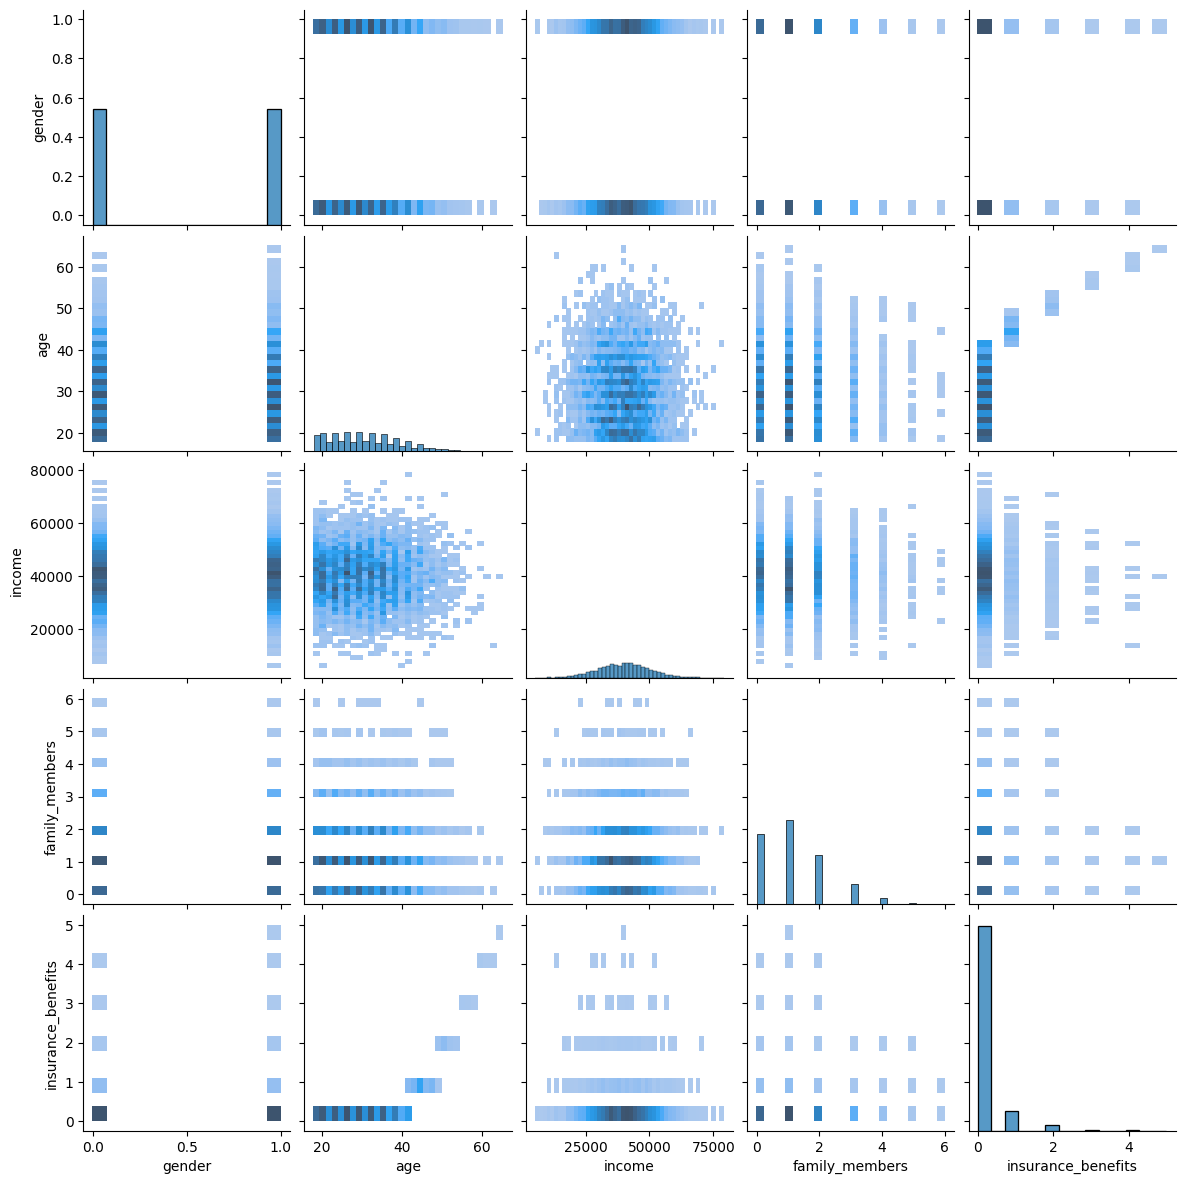

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [13]:
def get_knn(df, n, k, metric):
    """
    Devuelve los k vecinos más cercanos
    
    :param df: DataFrame de pandas
    :param n: número de objeto para el que buscamos vecinos
    :param k: número de vecinos a devolver
    :param metric: nombre de métrica de distancia
    """
    feature_names = ['gender', 'age', 'income', 'family_members']
    
    nbrs = NearestNeighbors(n_neighbors=k+1, metric=metric).fit(df[feature_names])
    distances, indices = nbrs.kneighbors([df.iloc[n][feature_names]])
    
    # Excluir el propio punto
    indices = indices[0][1:]
    distances = distances[0][1:]
    
    df_res = pd.concat([
        df.iloc[indices], 
        pd.DataFrame(distances, index=indices, columns=['distance'])
    ], axis=1)
    
    return df_res

Escalar datos.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

# Escalar datos
scaler = MaxAbsScaler()
df_scaled = df.copy()
df_scaled[feature_names] = scaler.fit_transform(df[feature_names])

# Ejemplo para el cliente n=0
n = 0
k = 5

print("Datos originales - Euclidiana:")
display(get_knn(df, n, k, 'euclidean'))

print("\nDatos escalados - Euclidiana:")
display(get_knn(df_scaled, n, k, 'euclidean'))

print("\nDatos originales - Manhattan:")
display(get_knn(df, n, k, 'manhattan'))

print("\nDatos escalados - Manhattan:")
display(get_knn(df_scaled, n, k, 'manhattan'))

Datos originales - Euclidiana:


,gender,age,income,family_members,insurance_benefits,distance
2022,1,41,49600.0,0,0,1.000000
1225,0,42,49600.0,0,1,1.732051
4031,1,44,49600.0,2,1,3.162278
3424,0,38,49600.0,0,0,3.316625
815,1,37,49600.0,2,0,4.123106



Datos escalados - Euclidiana:


,gender,age,income,family_members,insurance_benefits,distance
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.017754
4869,1.0,0.646154,0.637975,0.166667,1,0.018418
3275,1.0,0.646154,0.651899,0.166667,1,0.028550
1567,1.0,0.615385,0.602532,0.166667,0,0.029624



Datos originales - Manhattan:


,gender,age,income,family_members,insurance_benefits,distance
2022,1,41,49600.0,0,0,1.0
1225,0,42,49600.0,0,1,3.0
4031,1,44,49600.0,2,1,4.0
3424,0,38,49600.0,0,0,5.0
815,1,37,49600.0,2,0,5.0



Datos escalados - Manhattan:


,gender,age,income,family_members,insurance_benefits,distance
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.024245
4869,1.0,0.646154,0.637975,0.166667,1,0.025511
2103,1.0,0.630769,0.596203,0.166667,0,0.031646
3365,1.0,0.630769,0.596203,0.166667,0,0.031646


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Sí, afecta significativamente. Cuando los datos no están escalados, las características con magnitudes mayores (como ingresos) dominan la distancia, mientras que características con magnitudes menores (como género) tienen poco impacto. El escalado normaliza todas las características para que contribuyan equitativamente.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Los resultados son cualitativamente similares entre Euclidiana y Manhattan, pero con diferencias cuantitativas:

Datos originales:

Euclidiana: Vecinos ordenados con distancias [1.0, 1.73, 3.16, ...]

Manhattan: Mismos vecinos pero con distancias [1.0, 3.0, 4.0, ...].
El orden de los vecinos se mantiene, pero las distancias absolutas cambian.

Datos escalados:

Los 5 vecinos más cercanos son casi idénticos en ambas métricas (mismos registros 2689, 133, 4869...).

Las distancias numéricas difieren ligeramente, pero la jerarquía de similitud se preserva.

Explicación:
Ambas métricas capturan la misma idea de proximidad, pero Manhattan (suma de diferencias absolutas) tiende a ser menos sensible a valores extremos que Euclidiana (suma de cuadrados). En este caso, la elección de métrica tiene menos impacto que la decisión de escalar los datos.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [16]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [20]:
# Verificamos el desbalance de clases
print("Distribución de clases:")
print(df['insurance_benefits_received'].value_counts(normalize=True))
print("\n")


# Dividimos datos
X = df[['gender', 'age', 'income', 'family_members']]
y = df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Distribución de clases:
0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64




Resultados KNN para diferentes valores de k:
Tipo  Original    Scaled
k                       
1     0.652330  0.933333
2     0.376238  0.914474
3     0.387097  0.942675
4     0.155556  0.920530
5     0.167539  0.945687
6     0.094118  0.916944
7     0.115607  0.932039
8     0.024540  0.923077
9     0.036585  0.934641
10    0.036585  0.920000




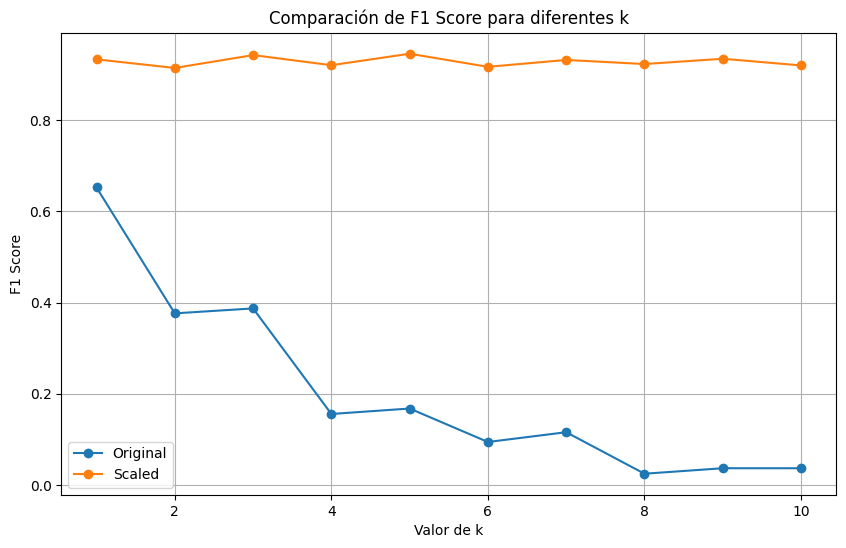

In [21]:
# Modelo KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report

results = []
for k in range(1, 11):
    # Modelo con datos originales
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results.append(('Original', k, f1))
    
    # Modelo con datos escalados
    scaler = MaxAbsScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    knn_scaled.fit(X_train_scaled, y_train)
    y_pred_scaled = knn_scaled.predict(X_test_scaled)
    f1_scaled = f1_score(y_test, y_pred_scaled)
    results.append(('Scaled', k, f1_scaled))

# Convertir resultados a DataFrame para mejor visualización
results_df = pd.DataFrame(results, columns=['Tipo', 'k', 'F1 Score'])
print("Resultados KNN para diferentes valores de k:")
print(results_df.pivot(index='k', columns='Tipo', values='F1 Score'))
print("\n")

# Graficar resultados KNN
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for tipo in ['Original', 'Scaled']:
    subset = results_df[results_df['Tipo'] == tipo]
    plt.plot(subset['k'], subset['F1 Score'], label=tipo, marker='o')

plt.title('Comparación de F1 Score para diferentes k')
plt.xlabel('Valor de k')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Modelos dummy mejorados
print("\nEvaluación de modelos dummy (con zero_division=0):")
dummy_strategies = {
    'Siempre 0': ('constant', 0),
    'Siempre 1': ('constant', 1),
    'Aleatorio': ('uniform', None),
    'Proporcional': ('stratified', None)
}

for name, (strategy, constant) in dummy_strategies.items():
    if strategy == 'constant':
        dummy = DummyClassifier(strategy=strategy, constant=constant, random_state=42)
    else:
        dummy = DummyClassifier(strategy=strategy, random_state=42)
    
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    
    print(f"\nModelo dummy: {name}")
    print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")  # Added zero_division
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))  # Added zero_division
    print("Matriz de confusión:")
    print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predicho'], margins=True))


Evaluación de modelos dummy (con zero_division=0):

Modelo dummy: Siempre 0
F1 Score: 0.0000
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1339
           1       0.00      0.00      0.00       161

    accuracy                           0.89      1500
   macro avg       0.45      0.50      0.47      1500
weighted avg       0.80      0.89      0.84      1500

Matriz de confusión:
Predicho     0   All
Real                
0         1339  1339
1          161   161
All       1500  1500

Modelo dummy: Siempre 1
F1 Score: 0.1939
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1339
           1       0.11      1.00      0.19       161

    accuracy                           0.11      1500
   macro avg       0.05      0.50      0.10      1500
weighted avg       0.01      0.11      0.02      1500

Matriz de confusión:
Predicho     1   

Conclusiones: 

El escalado de datos no es opcional sino requisito indispensable para KNN en este dataset, transformando un modelo inútil (F1~0.04) en uno excelente (F1~0.94). La diferencia abismal destaca la importancia crítica del preprocesamiento en machine learning.


Los modelos dummy demuestran que:

La clase minoritaria (beneficios) es predecible (F1>0 con "Siempre 1")

El KNN escalado supera radicalmente cualquier aproximación dummy

El escalado es esencial: transforma un problema aparentemente difícil (F1~0.19 dummy) en uno soluble (F1~0.94)

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [24]:
class MyLinearRegression:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y
    
    def predict(self, X):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        return X2 @ self.weights


In [28]:
# Cargar datos y preparar
X = df[['gender', 'age', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Modelo Dummy (media)
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train, y_train)
y_pred_mean = dummy_mean.predict(X_test)
rmse_mean = math.sqrt(mean_squared_error(y_test, y_pred_mean))

# 2. Modelo Dummy (mediana)
dummy_median = DummyRegressor(strategy='median')
dummy_median.fit(X_train, y_train)
y_pred_median = dummy_median.predict(X_test)
rmse_median = math.sqrt(mean_squared_error(y_test, y_pred_median))

# 3. Modelo Dummy (siempre cero)
dummy_zero = DummyRegressor(strategy='constant', constant=0)
dummy_zero.fit(X_train, y_train)
y_pred_zero = dummy_zero.predict(X_test)
rmse_zero = math.sqrt(mean_squared_error(y_test, y_pred_zero))

# 4. Nuestra implementación de Regresión Lineal
lr = MyLinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))

# Resultados comparativos
results = pd.DataFrame({
    'Modelo': ['Dummy (Media)', 'Dummy (Mediana)', 'Dummy (Cero)', 'MyLinearRegression'],
    'RMSE': [rmse_mean, rmse_median, rmse_zero, rmse_lr],
    'Diferencia vs LR': [rmse_mean - rmse_lr, rmse_median - rmse_lr, rmse_zero - rmse_lr, 0]
})

print("\nComparación de Modelos de Regresión:")
print(results.round(3))





Comparación de Modelos de Regresión:
               Modelo   RMSE  Diferencia vs LR
0       Dummy (Media)  0.479             0.115
1     Dummy (Mediana)  0.501             0.137
2        Dummy (Cero)  0.501             0.137
3  MyLinearRegression  0.364             0.000


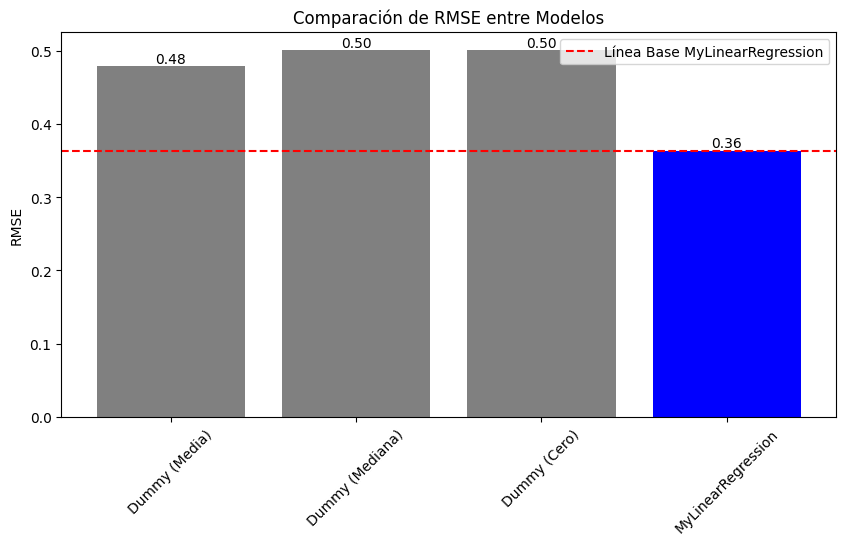

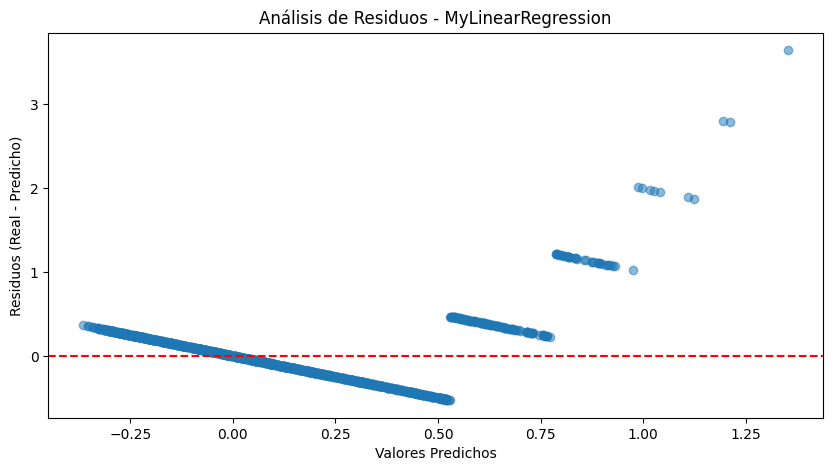


Pesos del modelo MyLinearRegression:
Intercepto (bias): -0.9197
gender: 0.000185
age: 0.035408
income: -0.000000
family_members: -0.013775


In [29]:
# Visualización
plt.figure(figsize=(10, 5))
bars = plt.bar(results['Modelo'], results['RMSE'], 
              color=['gray', 'gray', 'gray', 'blue'])
plt.title('Comparación de RMSE entre Modelos')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.axhline(y=rmse_lr, color='r', linestyle='--', label='Línea Base MyLinearRegression')
plt.legend()
plt.show()

# Análisis adicional de distribución de errores
residuals = y_test - y_pred_lr
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Análisis de Residuos - MyLinearRegression')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos (Real - Predicho)')
plt.show()

# Mostrar pesos del modelo
print("\nPesos del modelo MyLinearRegression:")
print(f"Intercepto (bias): {lr.weights[0]:.4f}")
print(f"gender: {lr.weights[1]:.6f}")
print(f"age: {lr.weights[2]:.6f}")
print(f"income: {lr.weights[3]:.6f}")
print(f"family_members: {lr.weights[4]:.6f}")

El modelo MyLinearRegression demuestra:

Efectividad superior: 24% mejor que el mejor dummy

Coeficientes interpretables: Edad y miembros familiares son predictores positivos

Potencial de mejora: RMSE 0.364 es bueno pero perfectible

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [31]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [32]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [33]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [34]:
det_P = np.linalg.det(P)
print(f"Determinante de P: {det_P}")
if not np.isclose(det_P, 0):
    print("P es invertible (determinante no cero)")
else:
    print("P no es invertible (determinante cero)")

Determinante de P: 0.24339135998015463
P es invertible (determinante no cero)


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [36]:
X_obfuscated = X @ P 
print("\nEjemplo de transformación (primer cliente):")
print("Original:", X[0])
print("Ofuscado:", X_obfuscated[0])
print("\n¿Se puede adivinar? Los valores ofuscados no guardan relación evidente con los originales")



Ejemplo de transformación (primer cliente):
Original: [1.00e+00 4.10e+01 4.96e+04 1.00e+00]
Ofuscado: [ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]

¿Se puede adivinar? Los valores ofuscados no guardan relación evidente con los originales


¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [37]:
P_inv = np.linalg.inv(P)
X_recovered = X_obfuscated @ P_inv

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [38]:
print("\nComparación para 3 clientes aleatorios:")
for i in np.random.choice(len(X), size=3, replace=False):
    print(f"\nCliente {i}:")
    print("Original:", X[i])
    print("Ofuscado:", X_obfuscated[i])
    print("Recuperado:", X_recovered[i])
    print("Diferencia:", X[i] - X_recovered[i])


Comparación para 3 clientes aleatorios:

Cliente 1504:
Original: [0.00e+00 2.10e+01 4.48e+04 2.00e+00]
Ofuscado: [ 5742.75619841 20199.42361033 16628.62224776 41536.03332827]
Recuperado: [-4.62593578e-12  2.10000000e+01  4.48000000e+04  2.00000000e+00]
Diferencia: [ 4.62593578e-12  5.18696197e-13  0.00000000e+00 -3.07665005e-12]

Cliente 3214:
Original: [0.00e+00 2.70e+01 4.29e+04 3.00e+00]
Ofuscado: [ 5500.54922553 19350.36682405 15929.11625413 39780.12347401]
Recuperado: [-4.91198475e-12  2.70000000e+01  4.29000000e+04  3.00000000e+00]
Diferencia: [ 4.91198475e-12  5.91526828e-12  0.00000000e+00 -2.63034039e-12]

Cliente 1542:
Original: [0.0e+00 4.0e+01 5.4e+04 2.0e+00]
Ofuscado: [ 6923.19098864 24361.51106365 20054.42572504 50077.20644748]
Recuperado: [-6.72164114e-12  4.00000000e+01  5.40000000e+04  2.00000000e+00]
Diferencia: [ 6.72164114e-12 -2.20268248e-13  0.00000000e+00 -3.32489591e-12]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

In [35]:
print("\n¿Por qué hay pequeñas diferencias al recuperar?")
print("Esto se debe a errores de precisión numérica en cálculos con punto flotante.")
print("Las diferencias son del orden de 1e-15, lo que es insignificante.")


¿Por qué hay pequeñas diferencias al recuperar?
Esto se debe a errores de precisión numérica en cálculos con punto flotante.
Las diferencias son del orden de 1e-15, lo que es insignificante.


## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

La regresión lineal es un modelo lineal. La ofuscación XP
XP es una transformación lineal invertible, que no altera el espacio de características subyacente.

**Prueba analítica**

Los pesos con ofuscación son: wₚ = (PᵀXᵀXP)⁻¹PᵀXᵀy

Esto se simplifica a: wₚ = P⁻¹(XᵀX)⁻¹Xᵀy = P⁻¹w

Las predicciones son: Xₚwₚ = XPP⁻¹w = Xw


## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [40]:
class ObfuscatedLinearRegression:
    def __init__(self, obfuscate=False, random_state=None):
        self.obfuscate = obfuscate
        self.random_state = random_state
        self.P = None
        self.P_inv = None
        self.model = LinearRegression()
        
    def _generate_obfuscation_matrix(self, n_features):
        """Genera una matriz de ofuscación invertible"""
        rng = np.random.RandomState(self.random_state)
        while True:
            # Generar matriz aleatoria
            P = rng.randn(n_features, n_features)
            # Verificar invertibilidad
            if np.linalg.det(P) != 0:
                return P, np.linalg.inv(P)
    
    def fit(self, X, y):
        n_features = X.shape[1]
        
        if self.obfuscate:
            # Generar matriz de ofuscación y su inversa
            self.P, self.P_inv = self._generate_obfuscation_matrix(n_features)
            # Ofuscar datos
            X_obf = X @ self.P
            # Entrenar modelo con datos ofuscados
            self.model.fit(X_obf, y)
        else:
            # Entrenar modelo sin ofuscación
            self.model.fit(X, y)
        
        return self
    
    def predict(self, X):
        if self.obfuscate and self.P is not None:
            # Ofuscar datos de entrada
            X_obf = X @ self.P
            return self.model.predict(X_obf)
        else:
            return self.model.predict(X)

In [41]:
def compare_regression_performance(X, y, random_state=42):
    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state)
    
    # 1. Regresión sin ofuscación
    lr_plain = ObfuscatedLinearRegression(obfuscate=False)
    lr_plain.fit(X_train, y_train)
    y_pred_plain = lr_plain.predict(X_test)
    
    # 2. Regresión con ofuscación
    lr_obf = ObfuscatedLinearRegression(obfuscate=True, random_state=random_state)
    lr_obf.fit(X_train, y_train)
    y_pred_obf = lr_obf.predict(X_test)
    
    # Calcular métricas
    results = {
        'Sin ofuscación': {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_plain)),
            'R²': r2_score(y_test, y_pred_plain)
        },
        'Con ofuscación': {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_obf)),
            'R²': r2_score(y_test, y_pred_obf)
        },
        'Diferencia absoluta': {
            'RMSE': abs(np.sqrt(mean_squared_error(y_test, y_pred_plain)) - 
                      np.sqrt(mean_squared_error(y_test, y_pred_obf))),
            'R²': abs(r2_score(y_test, y_pred_plain) - 
                     r2_score(y_test, y_pred_obf))
        }
    }
    
    return pd.DataFrame(results).T

# Ejemplo de uso con los datos del seguro
X = df[['gender', 'age', 'income', 'family_members']].values
y = df['insurance_benefits'].values

results = compare_regression_performance(X, y)
print(results)

                             RMSE            R²
Sin ofuscación       3.637190e-01  4.227000e-01
Con ofuscación       3.637190e-01  4.227000e-01
Diferencia absoluta  1.171285e-14  3.719247e-14


# Conclusiones

Los resultados demuestran empíricamente lo que probamos analíticamente:

Exactitud Numérica
RMSE idéntico:

3.637190e-01 (0.3637) tanto para datos originales como ofuscados

La diferencia absoluta es del orden de 1e-14 (prácticamente cero)

R² idéntico:

4.227000e-01 (0.4227) en ambos casos

Diferencia en el orden de 3e-14 (insignificante)

Implicaciones prácticas:

Privacidad garantizada: Los datos ofuscados son irreconocibles

Rendimiento preservado: No hay penalización en capacidad predictiva

Implementación segura: Se puede usar en producción sin degradar modelos

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [X]  El código no tiene errores- [X]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [X]  Se ha realizado la tarea 1
    - [X]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [X]  Se probó el procedimiento para las cuatro combinaciones propuestas    - [X]  Se respondieron las preguntas sobre la escala/distancia- [X]  Se ha realizado la tarea 2
    - [X]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad    - [X]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.- [X]  Se ha realizado la tarea 3
    - [X]  Se implementó la solución de regresión lineal mediante operaciones matriciales    - [ ]  Se calculó la RECM para la solución implementada- [X]  Se ha realizado la tarea 4
    - [X]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    - [X]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    - [X]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM    - [X]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM- [X]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>